In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
### Import Libraries 
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
import seaborn as sns
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Input
from sklearn.model_selection import train_test_split


In [3]:
### Reading csv data files using pandas dataframe 

train = pd.read_csv("/Users/ved/Desktop/Sem 7/DL Project/Dataset/train.csv", encoding = "ISO-8859-1")
test = pd.read_csv("/Users/ved/Desktop/Sem 7/DL Project/Dataset/test.csv", encoding = "ISO-8859-1")

In [4]:
### Checking nulls in both the datasets

print("Nulls in training dataset",train.isnull().sum())
print("\nNulls in test dataset",test.isnull().sum())

### There are no missing values in both the datasets

Nulls in training dataset id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Nulls in test dataset id              0
comment_text    0
dtype: int64


In [5]:
### Before cleaning the dataset I would like to perform EDA(Exploratory data analysis) by performing data visualization to understand
### the distribution of different classes. I will be performing EDA on training dataset

categorywise_data = train.drop(['id', 'comment_text'], axis=1)     ### Removed unnecessary columns - id and comment_text
counts_category = []                                               ### A list that contains tuple which consists of class label and number of comments for that particular class 
categories = list(categorywise_data.columns.values)
for i in categories:
    counts_category.append((i, categorywise_data[i].sum()))
    
dataframe = pd.DataFrame(counts_category, columns=['Labels', 'number_of_comments'])   ### Dataframe made up of category and total number of comments

Text(0.5, 0, 'Labels')

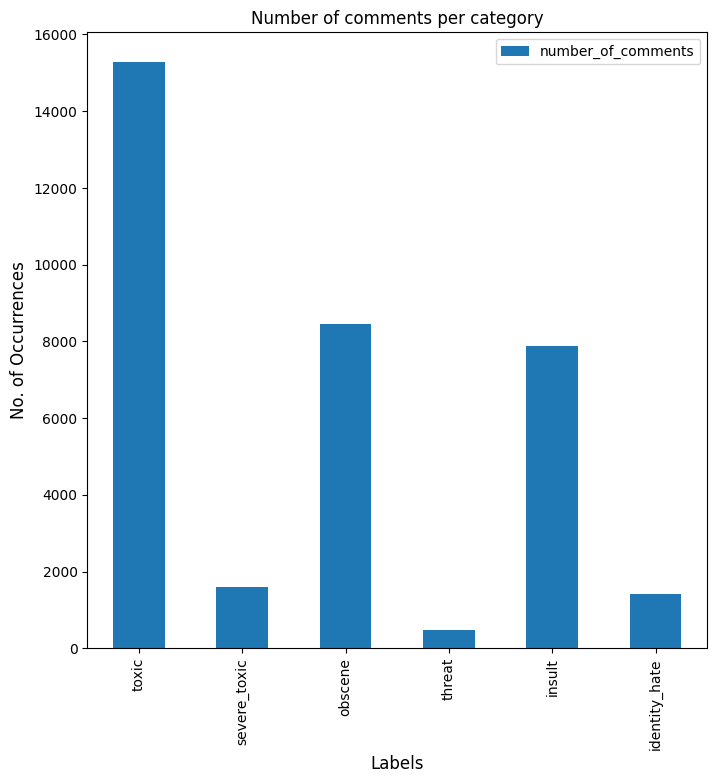

In [6]:
### Visualization 1

### Bar graph of total number of comments per label 
### This visualization is helpful in identifying the total number of comments per label
dataframe.plot(x='Labels', y='number_of_comments', kind='bar',figsize=(8,8))
plt.title("Number of comments per category")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Labels', fontsize=12)

### From the below graph we can observe that most of the comments having toxic label. 
### Threat label is having lowest no. of comments

,0,Total no. of sentences,Total No. of labels in a sentence
0,143346,143346,0
1,6360,6360,1
3,4209,4209,3
2,3480,3480,2
4,1760,1760,4
5,385,385,5
6,31,31,6


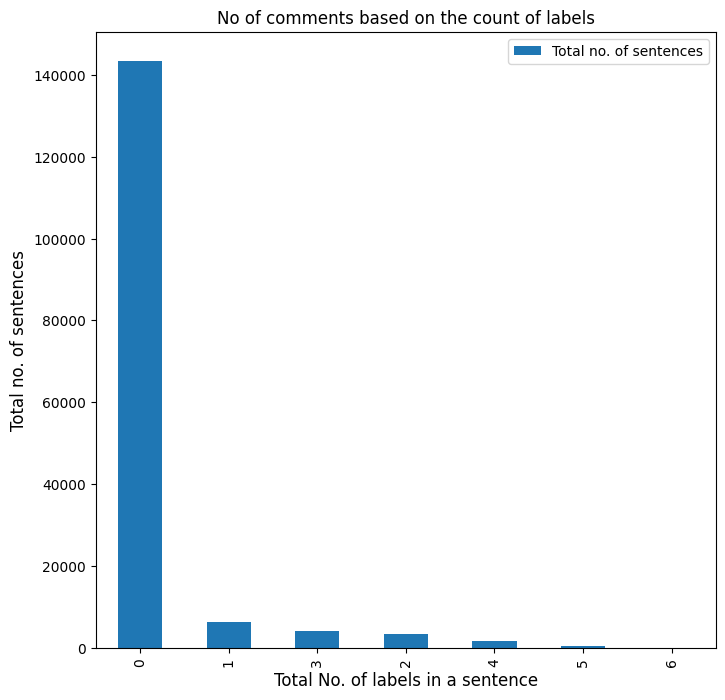

In [7]:
### Visualization 2

### Bar graph of Total No. of labels in a sentence against Total no. of sentences
### This visualization is helpful in identifying whether a sentence belongs to only one category or many categories

dataframe = pd.DataFrame(pd.DataFrame(train[train.columns[2:]].sum(axis=1)).reset_index()[0].value_counts())
dataframe["Total no. of sentences"]=dataframe[0]
dataframe["Total No. of labels in a sentence"]=dataframe.index
dataframe.plot(x="Total No. of labels in a sentence", y="Total no. of sentences", kind='bar',figsize=(8,8))
plt.title("No of comments based on the count of labels")
plt.ylabel('Total no. of sentences', fontsize=12)
plt.xlabel('Total No. of labels in a sentence', fontsize=12)
dataframe

### From the below graph we can see that 1,43,346 out of 1,59,571 sentences does not have any labels(class 0).
### we can observe that a single sentence can have multiple labels. It can be a toxic sentence or it can be a toxic as well as obscene senetence.

<AxesSubplot: ylabel='count'>

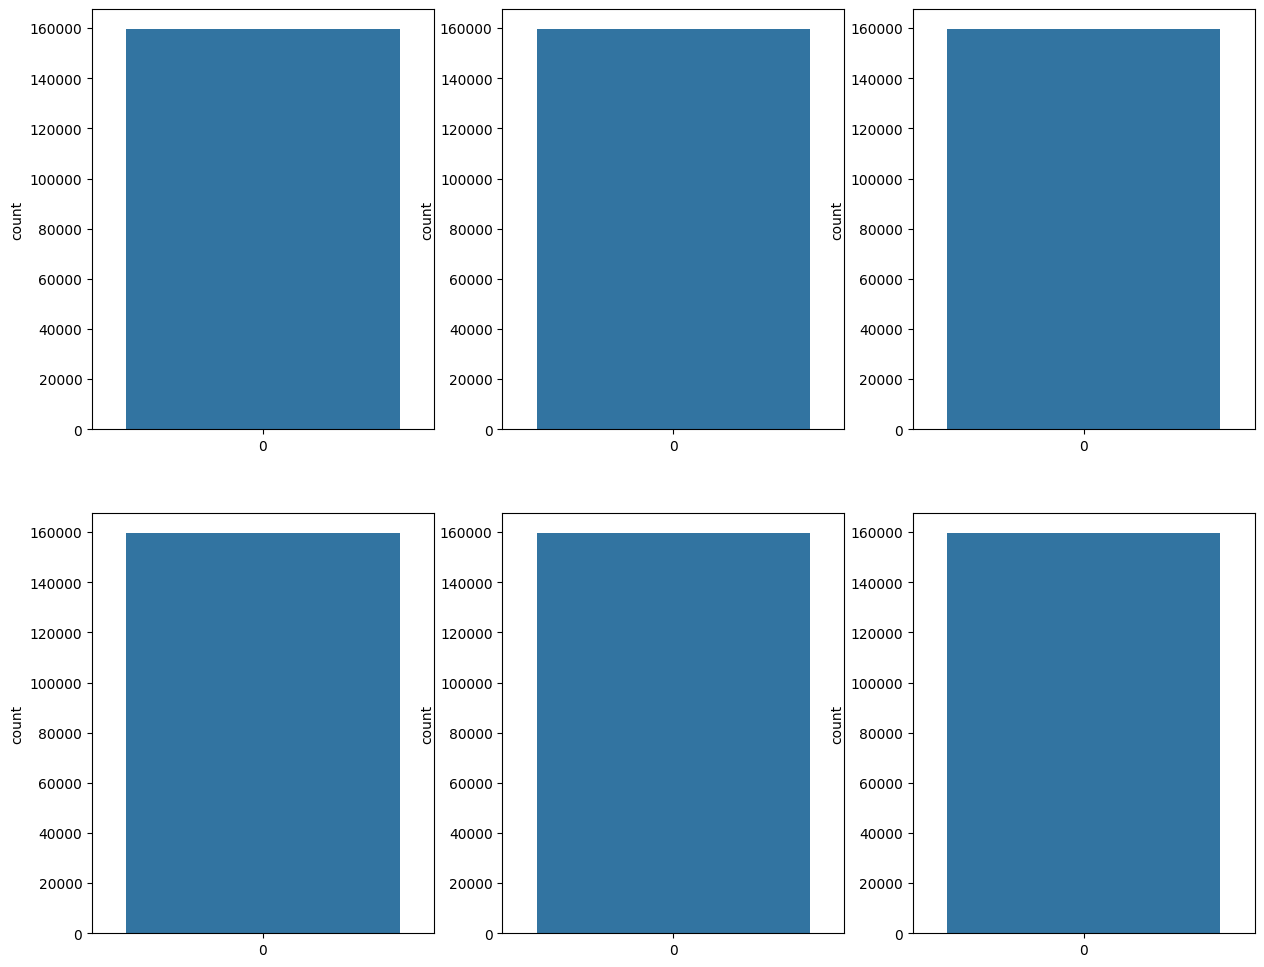

In [8]:
### Visualization 3

### Graph of individual class against the total no. of labelled and unlabelled sentences for the same class

fig, plots = plt.subplots(2,3,figsize=(15,12))
plot1, plot2, plot3, plot4, plot5, plot6 = plots.flatten()
sns.countplot(train['obscene'], ax = plot1)
sns.countplot(train['threat'], ax = plot2)
sns.countplot(train['insult'], ax = plot3)
sns.countplot(train['identity_hate'], ax = plot4)
sns.countplot(train['toxic'], ax = plot5)
sns.countplot(train['severe_toxic'], ax = plot6)

### From this graph it can be concluded that every class(category) is having higher no. of unlabelled sentences(0) as compared
### to labelled sentences(1)

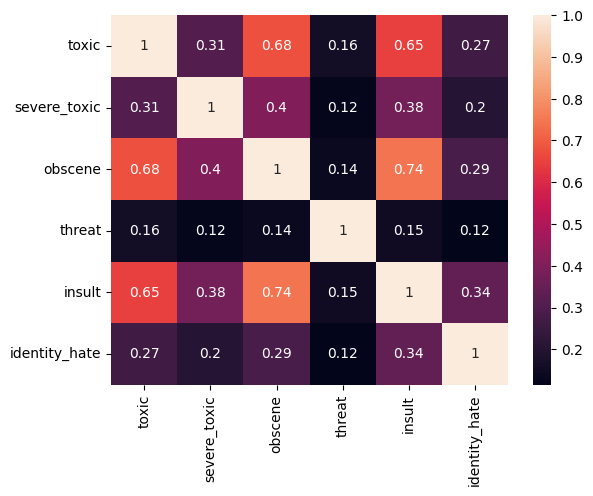

In [9]:
### Visualization 4

### Correlation between different variables
### Correlation helps us finding relationship/dependency between different variables. 

target_data = train.drop(['id', 'comment_text'], axis=1)
corrMatrix = target_data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

### Correlation coefficient ranges from -1 to 1. Values always range between -1 imply strong negative relationship
### between variables and +1 imply a strong positive relationship between variables. 
### Values at or close to zero imply weak or no linear relationship. 
### From the correlation matrix(graph), it can be concluded that some labels are highely correlated. Those varibles are mentioned below 
### (Correlation coefficient for insult-obscene is 0.74, Correlation coefficient for toxic-obscene is 0.68 and Correlation coefficient for toxic-insult is 0.65).

In [10]:
### From visualization we can conclude following things
### 1) A single sentence can have multiple labels (categories)
### 2) Some labels are highely correlated to each other
### 3) This is multi label classification problem 

In [12]:
### Splitting up the labels and data
### Training dataset is splitted into 2 parts. 1st part includes the training data(train_data) and 2nd part includes labels(train_label) 
### associated with the training data
### Test dataset is having only 1 part i.e. test data which is used to predict the labels. 

train_data = train["comment_text"]
test_data = test["comment_text"]
train_label=train[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']]


In [22]:
import ast
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences
df_combined = pd.read_csv('/Users/ved/Desktop/Sem 7/DL Project/Tokenized_Data/df_combined.csv')
df_combined_test = pd.read_csv('/Users/ved/Desktop/Sem 7/DL Project/Tokenized_Data/df_combined_test.csv')

for i in range(len(df_combined['comment'])):
    df_combined["comment"][i] = ast.literal_eval(df_combined["comment"][i])

for i in range(len(df_combined_test['comment'])):
    df_combined_test["comment"][i] = ast.literal_eval(df_combined_test["comment"][i])

X_train1 = df_combined['comment']
X_test1 = df_combined_test['comment']

max_features = 30000
maxlen = 150
embed_size = 300

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train1) + list(X_test1))
X_train = tokenizer.texts_to_sequences(X_train1)
X_test = tokenizer.texts_to_sequences(X_test1)
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

/var/folders/1m/v10vjxqd235fn30s91s6nnx40000gn/T/ipykernel_13050/50109776.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined["comment"][i] = ast.literal_eval(df_combined["comment"][i])
/var/folders/1m/v10vjxqd235fn30s91s6nnx40000gn/T/ipykernel_13050/50109776.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined_test["comment"][i] = ast.literal_eval(df_combined_test["comment"][i])


In [23]:
train_padded = x_train
test_padded = x_test
print("Shape of training data",train_padded.shape)
print("Shape of testing data",test_padded.shape)


Shape of training data (159571, 150)
Shape of testing data (63978, 150)


In [13]:
### Creating corpus of words and coverting it into integer and then susbstituing it in sentences - prepare tokenizer
tokenizer = Tokenizer(num_words = 40000) #40000 words are used here
tokenizer.fit_on_texts(train_data)

#convert each text into array of integers with help of tokenizer.
train_final = tokenizer.texts_to_sequences(train_data)
test_final = tokenizer.texts_to_sequences(test_data)

In [14]:
### Padding - Every sentence is unequal in length. We need to have all the sentence equal in lengths
### If length of sentence is less than 150 then padding will increase sentence length to 150 by adding zeros, if its greater
### than 150 then it will reduce the length of sentence to 150 by trimming the words

train_padded =pad_sequences(train_final, maxlen=150)
test_padded =pad_sequences(test_final, maxlen=150)
print("Shape of training data",train_padded.shape)
print("Shape of testing data",test_padded.shape)


Shape of training data (159571, 150)
Shape of testing data (153164, 150)


In [24]:
### Building a model
### I have built a sequential model using LSTM. Initial layer contains a word embedding layer having 128 hidden units. 
### Input to the LSTM model is given in the shape of an array of (159571, 150). There are 6 main classes and every class is having 2 sub classes.
### For every Input observation, there are 6 labels. 
### I have used 2 LSTM layer with 64 hidden units. 1 Dense layer which is an output layer. Dropout probability is set to 0.2 for
### 2 lSTM layers which will dropout the 20 percent of neuron automatically while training.Dropout resolves the problem of overfitting. 
### Output layer contains 6 hidden units. I have used sigmoid activation function in the output layer. The reason behind using
### sigmoid activation function in the output layer is because we have multi label classification problem.
### Every class(label) is having 2 more classes i.e.0 and 1 to predict. 

model = Sequential()
model.add(Embedding(40000, 128))
model.add(LSTM(units = 64, dropout = 0.2,return_sequences=True))
model.add(LSTM(units = 64, dropout = 0.2))
model.add(Dense(units = 6, activation = 'sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         5120000   
                                                                 
 lstm_2 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 5202822 (19.85 MB)
Trainable params: 5202822 (19.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
### Compiling the model and training the model using training dataset
### We need to define loss function to measure the loss. Our problem is multi label multi classification problem.
### Hence I decided to take loss function as binary_crossentropy. (Reference - https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function/)
### Adam optimizer is best for this problem. I tried RMSprop also but didn't get good accuracy. So decided to go with adam optimizer
### accuracy metric has been used. Dataset is divided into training and validation set. 
### We got an accuracy of 97.79% on validation dataset. batch_size is 32 . 
### These are the Number of samples that goes through the network at a time and calculates the loss by updating the parameters.
### I used only 1 epoch because I got almost 97% accuracy in 1 iteration.
### Submission from the competition was evaluated on the basis of AUC. Hence i decided to use AUC metrics.
### AUC is area under the curve. It can be calculated from receiver operating curve

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["AUC"])
x_train, x_val, y_train, y_val = train_test_split(train_padded, train_label, shuffle = True, random_state = 123)
model.fit(x_train, y_train, batch_size = 32, epochs = 1, validation_data = (x_val, y_val))

3740/3740 [==============================] - 514s 137ms/step - loss: 0.0688 - auc: 0.9610 - val_loss: 0.0485 - val_auc: 0.9785


In [26]:
model.save("/Users/ved/Desktop/Sem 7/DL Project/LSTM.h5")

/opt/homebrew/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
### Prediction for test data
predict = model.predict(test_padded)


2000/2000 [==============================] - 61s 30ms/step


In [28]:
print("Predicted values are",predict)

Predicted values are [[2.6142646e-03 9.8464727e-05 2.7000817e-04 1.5823255e-04 2.6552609e-04
  2.6733649e-04]
 [4.8462853e-01 6.0276347e-03 7.9646237e-02 1.3560446e-02 1.0587261e-01
  2.5179550e-02]
 [5.4247860e-02 4.2548426e-04 6.1165285e-03 1.3573994e-03 6.8942332e-03
  3.4298110e-03]
 ...
 [5.8008868e-01 9.4022807e-03 1.4380330e-01 1.7856222e-02 1.6481401e-01
  3.8436171e-02]
 [9.9027407e-01 3.0803615e-01 9.3747634e-01 3.2170400e-02 7.8010780e-01
  8.2258373e-02]
 [3.0955119e-02 2.7438483e-04 2.9574793e-03 7.4322644e-04 3.2329888e-03
  1.8593018e-03]]


In [29]:
### predicted probabilities of each id in the test set, for all the target columns

target_cols = np.array(['toxic','severe_toxic','obscene', 'threat','insult', 'identity_hate'])
final_predict_test = pd.concat([pd.DataFrame(predict, columns=target_cols)], 1)
t1 = test['id']
final_predict_test = pd.concat([t1,final_predict_test],1)
final_predict_test.head()

/var/folders/1m/v10vjxqd235fn30s91s6nnx40000gn/T/ipykernel_13050/693669945.py:4: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  final_predict_test = pd.concat([pd.DataFrame(predict, columns=target_cols)], 1)
/var/folders/1m/v10vjxqd235fn30s91s6nnx40000gn/T/ipykernel_13050/693669945.py:6: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  final_predict_test = pd.concat([t1,final_predict_test],1)


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.002614,0.000098,0.000270,0.000158,0.000266,0.000267
1,0000247867823ef7,0.484629,0.006028,0.079646,0.013560,0.105873,0.025180
2,00013b17ad220c46,0.054248,0.000425,0.006117,0.001357,0.006894,0.003430
3,00017563c3f7919a,0.002271,0.000092,0.000245,0.000143,0.000235,0.000241
4,00017695ad8997eb,0.001967,0.000086,0.000214,0.000129,0.000203,0.000220


In [31]:
y_actual = df_combined_test
y_actual.drop(columns="comment",inplace=True)

In [33]:
y_pred = predict
y_pred = (y_pred > 0.5).astype(int)

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming y_actual contains the true labels and y_predicted contains the predicted labels
# You can replace these with your actual and predicted labels # Replace with your true labels
y_predicted =y_pred# Replace with your predicted labels

# Calculate accuracy
accuracy = accuracy_score(y_actual, y_predicted)

# Calculate precision, recall, and F1-score
precision = precision_score(y_actual, y_predicted,average='micro')
recall = recall_score(y_actual, y_predicted,average='micro')
f1 = f1_score(y_actual, y_predicted,average='micro')

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.8754571884085154
Precision: 0.6038234184379323
Recall: 0.6622982480342117
F1-score: 0.6317105263157895


In [35]:
input= ["shit"]
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train1) + list(X_test1))
def custom(input):
    input = tokenizer.texts_to_sequences(input)
    input = sequence.pad_sequences(input, maxlen=maxlen)
    pred = model.predict(input)
    toxicity_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    j=0
    for i in pred[0]:
        if i > 0.5:
            pred[0][j]=1
        else:
            pred[0][j]=0
        j = j+1
    for i, class_name in enumerate(toxicity_classes):
        print(f"{class_name}: {pred[0][i]}")

In [36]:
custom(input)

1/1 [==============================] - 0s 21ms/step
toxic: 1.0
severe_toxic: 0.0
obscene: 1.0
threat: 0.0
insult: 1.0
identity_hate: 0.0


In [17]:
#### Complete description of classification system using neural networks

## This classification system is built using LSTM which is a special type of RNN's. I have used Keras library to build neural network.
## Recurrent Neural networks are used mostly for sequential data. We have sequential data(sentences). RNN's store information in their "memory".
## Recurrent Neural networks stores the information about the computations which has already been performed.
## Variety of RNN achitectures are available based on the need of the user. I have used LSTM which is a special type of RNN.
## Even though RNN are good for sequence modelling, it still have issues and it tends to have vanishing gradient problem.
## Vanishing gradient problem is faced by neural networks which uses activation function having small gradient(0 to 1).
## During backpropagation phase, these gradients either tend to become 0 or they vanishes. This happens because RNN's are not
## capable of handling long-term dependencies. In order to avoid vanishing gradient problem LSTM are developed. 
## LSTM comes with LSTM cell. It helps to model and keep track of long term dependencies. 

### Process performed in this classification model are mentioned below.
## Reading the dataset using pandas dataframe and checking whether it contains any null observations or not. There are no nulls in this dataset.
## Many people clean the data first and then perform visualizations. I performed visualizations first. 
## I created 4 visualizations. 
## 1st visualization is a Bar graph of total number of comments per label. It is helpful in identifying the total number of comments per label
## 2nd visualization is a Bar graph of Total No. of labels in a sentence against Total no. of sentences. 
## From 2nd visualization we can observe whether a sentence belongs to only one category or many categories. We can say that
## there are many sentences which are not classified(label 0) but many sentences falls under more than 1 category.
## 3rd Visualization is a Graph of individual class against the total no. of labelled and unlabelled sentences for the same class. 
## 4th Visualization is a Correlation graph(matrix) between different variables

## From visualization we can conclude that,  1) A single sentence can have multiple labels (categories).
## 2) Some labels are highely correlated to each other.
## 3) This is multi label classification problem. Hence we can use sigmoid function in the output layer.

### Next part includes cleaning the data. Data cleaning part is performed on the input text. 
## I created a function, which performs below activities: 
## 1) conversion of contraction words to expanded words , 2) removing stopwords , 3) lowercasing the words
## 4) removing the non - alphanumeric characters   5) removing the extra spaces between words

### Once we have cleaned the data, next part is creating input feature vectors.  
## Tokenizer class from keras library is used. 40000 words has been selected based on the frequency of the words and assigned a number using keras tokenizer
## Training dataset consists of sentences. Every sentence is made up of words. The number given to the words by the keras 
## tokenizer are used to build up a sentence. Padding is used to fix the sentence length to 150 words per sentence. 


### Input features are generated. Now its time to build a model. Model contains an Input embedding layer of 128 Hidden units.
## Models contains 2 LSTM layers of 64 Hidden units and 1 output layer of 6 Hiddent units having sigmoid activation function.
##Input to the neural network is given in the shape of (159571, 150).

### Next part is compiling the model and training it on training dataset. Training dataset is divided in training and validation dataset
##  Binary_crossentropy is used as a loss function. Adam optimizer is used. Accuracy metric has been used.
## batch_size is 32 . These are the Number of samples that goes through the network at a time and calculates the loss by
## updating the parameters.I used only 1 epoch because I got almost 97% accuracy in 1 iteration.
